## Classificação do Fashion MNIST com NN simples e Regressão Logística

Funções das Redes Neurais

In [2]:
import re
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


'''Criando a funcao de normalização de um dataframe inteiro
    input:
        df: Dataframe
    output:
        df: Dataframe com valores normalizados
'''
def normalize_dataframe(df):
    for column in df:
        df[column] = df[column]/255
    return df


'''Funcao para aplicar relu em um vetor
    input:
        z: weights * params + bias
    output:
        s: 0 para valores negativos z para valores positivos aplicado em cada amostra
'''    
def relu(z):
    return np.maximum(z, 0)


'''Funcao para aplicar a derivada da relu em um vetor
    input:
        z: weights * params + bias
    output:
        s: 0 para valores negativos 1 para valores positivos aplicado em cada amostra
'''    
def relu_(z):
    return np.array(z>0).astype(int)


'''Funcao para aplicar sigmoid em um vetor
    input:
        z: weights * params + bias
    output:
        s: valor entre 0-1 da aplicação da função para cada amostra
'''
def sigmoid(z):
    #print(z.shape)
    s = 1 / (1 + np.exp(-z))
    return s


'''Funcao para aplicar a derivada da sigmoid em um vetor
    input:
        z: weights * params + bias
    output:
        p: taxa de variação da sigmoid para cada amostra
'''
def sigmoid_(z):
    #print(sigmoid(Z1).shape)
    s = sigmoid(z) * (1 - sigmoid(z))
    return s


'''Funcao para calcular a tangente hiporbólica em um vetor
    input:
        x: weights * params + bias
    output:
        s: valor entre 0-1 da aplicação da função para cada amostra
'''
def tanh(x):
    s = (2 / (1 + np.exp(-2*x))) -1
    return s


'''Funcao para calcular a derivada da tangente hiporbólica em um vetor
    input:
        x: weights * params + bias
    output:
        s: porcentagem de chance do valor ser da classe predita para cada amostra
'''
def tanh_(x):
    s = 1 - tanh(x)**2
    return s


'''Funcao para calcular o erro médio da predição utilizando cross-entropy (Não pode ser utilizada com Relu, mas ok na output com softmax)
    input:
        Y: Labels
        Y_pred: Labels Preditas
    output:
        custo: erro médio da predição
'''
def cross_entropy_loss(Y, Y_pred):
    samples_number = Y.shape[1]
    custo = -(1./samples_number) * ( np.sum( np.multiply(np.log(Y_pred),Y) ) + np.sum( np.multiply(np.log(1-Y_pred),(1-Y)) ) )
    return custo


'''Funcao para calcular o erro médio da predição utilizando cross-entropy multiclasse (Não pode ser utilizada com Relu, mas ok na output com softmax)
    input:
        Y: Labels
        Y_pred: Labels Preditas
    output:
        custo: erro médio da predição
'''
def multiclass_cross_entropy_loss(Y, Y_pred):

    aux = np.sum(np.multiply(Y, np.log(Y_pred)))
    samples_number = Y.shape[1]
    custo = -(1/samples_number) * aux

    return custo
    

'''Funcao para calcular a probabilidade de ser de cada classe
    input:
        z: entrada da camada de saída
    output:
        p: probabilidade de ser de cada classe
'''
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)


'''Funcao para calcular a matriz de confusão
    input:
        Y: labels corretas
        Y_pred: labels preditas
        classes: numéro de classes
    output:
        confusion_matrix: matriz de confusão
'''
def get_confusion_matrix(Y, Y_pred, classes):
    
    if(Y_pred.max() != 1):
        Y_pred = binarize_labels(Y_pred)
    
    confusion_matrix = np.zeros((classes,classes)).astype(int)
    
    for y in range (Y.shape[1]):
        for c_pred in range (classes):
            if(Y_pred[c_pred, y] == 1):
                for c in range (classes):
                    if(Y[c, y] == 1):
                        confusion_matrix[c, c_pred]+=1
    
    return confusion_matrix

'''Funcao para converter um vetor de probabilidades de classes em one-hot-encoding
    input:
        L: vetor de probabilidade das labels
    output:
        Y_pred: vetor de labels (one-hot-encoding) 
    Ex: 
        Y_pred[:,1] = [0,1,0,0,0,0,0,0,0,0] quer dizer que a classe da sample 1 é 2
'''
def binarize_labels(L):
    samples_number = L.shape[1]
    classes = L.shape[0]
    
    Y_pred = np.argmax(L, axis=0).reshape(1, samples_number)

    y_aux = np.eye(classes)[Y_pred.astype('int32')]
    y_aux = y_aux.T.reshape(classes, samples_number)

    Y_pred = y_aux
    
    return Y_pred

'''Funcao para calcular a predição (Feed forward) de um dataframe dados parâmetros da rede neural com 1 camada escondida
    input:
        weights_1: vetor de pesos para calculo da entrada da camada escondida
        weights_2: vetor de pesos para calculo da entrada da camada de saída
        b1: vetor de pesos do bias para calculo da entrada da camada escondida
        b2: vetor de pesos do bias para calculo da entrada da camada de saída
        df: Dataframe a ser predito
        activation_function: qual função de ativação será usada nos neurônios (relu, sigmoid, tanh)
    output:
        ol_output: vetor contendo as labels preditas
'''
def predict_labels_1_hidden(weights_1, weights_2, b1, b2, df, activation_function):
    
    hl_input = np.matmul(weights_1,df.T) + b1
    hl_output = activation_function(hl_input)
    ol_input = np.matmul(weights_2,hl_output) + b2
    ol_output = softmax(ol_input)
    
    return ol_output

'''Funcao para calcular a predição (Feed forward) de um dataframe dados parâmetros de uma rede neural com 2 camadas escondidas
    input:
        weights_1: vetor de pesos para calculo da entrada da primeira camada escondida
        weights_2: vetor de pesos para calculo da entrada da segunda camada escondida
        weights_2: vetor de pesos para calculo da entrada da camada de saída
        b1: vetor de pesos do bias para calculo da entrada da primeira camada escondida
        b1: vetor de pesos do bias para calculo da entrada da segunda camada escondida
        b2: vetor de pesos do bias para calculo da entrada da camada de saída
        df: Dataframe a ser predito
        activation_function: qual função de ativação será usada nos neurônios (relu, sigmoid, tanh)
    output:
        ol_output: vetor contendo as labels preditas
'''
def predict_labels_2_hidden(weights_1, weights_2, weights_3, b1, b2, b3, df, activation_function):
    
    hl_1_input = np.matmul(weights_1,normalized_validation_df.T) + b1
    hl_1_output = activation_function(hl_1_input) 
    hl_2_input = np.matmul(weights_2,hl_1_output) + b2
    hl_2_output = activation_function(hl_2_input)
    ol_input = np.matmul(weights_3,hl_2_output) + b3
    ol_output = softmax(ol_input)
    
    return ol_output

'''Funcao para obter as métricas de performance: precision, recall e f1_score
    input:
        confusion_matrix: matriz de confusão (use get_confusion_matrix() para calculá-la)
    output:
        precision: relação entre a quantidade de positivos preditos pela quantidade real de positivos 
        recall: relação entre a quantidade de positivos esperados pela quantidade de positivos preditos
        f1_score: metrica para relacionar precision e recall em uma única métrica
'''
def get_metrics(confusion_matrix):
    precision = get_precision(confusion_matrix)
    recall = get_recall(confusion_matrix)
    f1_score = get_f1_score(precision, recall)
    
    return precision, recall, f1_score

def print_metrics(precision, recall, f1_score):
    precision = np.around(precision, decimals=2).reshape( precision.shape[0],1)
    recall = np.around(recall, decimals=2).reshape( recall.shape[0],1)
    f1_score = np.around(f1_score, decimals=2).reshape( f1_score.shape[0],1)
    
    average_precision = np.sum(precision)/precision.shape[0]
    average_recall = np.sum(recall)/recall.shape[0]
    average_f1_score = np.sum(f1_score)/f1_score.shape[0]
    
    print("\n\nPrecision (Pr), Recall (Re) and F1_Score (F1) of each class: ")
    print("Pr   Re    F1")
    print(re.sub(r' *\n *', '\n', np.array_str(np.c_[precision, recall, f1_score]).replace('[', '').replace(']', '').strip()))
    
    print("\n\nAverage Precision: ", round(average_precision,2) , "\nAverage Recall: ", round(average_recall, 2) ,"\nAverage F1_Score: ", round(average_f1_score,2))
    
    #print(precision," ", recall," ", f1_score)

def get_recall(confusion_matrix):
    precision = np.ones((confusion_matrix.shape[0]))
    for i in range (confusion_matrix.shape[0]):
        tp = confusion_matrix[i,i]
        tp_fp = np.sum(confusion_matrix[:,i])
        
        precision[i] = tp/tp_fp
        
    return precision

def get_precision(confusion_matrix):
    recall = np.ones(confusion_matrix.shape[0])
    
    for i in range (confusion_matrix.shape[0]):
        tp = confusion_matrix[i,i]
        tp_fn = np.sum(confusion_matrix[i,:])
        
        recall[i] = tp/tp_fn
        
    return recall

def get_f1_score(precision, recall):
    f1 = 2*( (precision*recall) / (precision+recall) )
    return f1

### Preparando os Dados

In [3]:
print("Loading Dataframe......")
df = pd.read_csv("data/fashion-mnist_train.csv")

print("Separating into training and validation.....")
#Separate the Training DF into Train and Validation
msk = np.random.rand(len(df)) < 0.7 

train_df = df[msk]
validation_df = df[~msk]

Y_train = train_df["label"]
Y_validation = validation_df["label"]

train_df = train_df.loc[:, train_df.columns != "label"]
validation_df = validation_df.loc[:, validation_df.columns != "label"]

#test_df = pd.read_csv("data/fashion-mnist_test.csv")

print("Normalizing (This may take a couple minutes).....")
normalized_train_df = normalize_dataframe(train_df)
normalized_validation_df = normalize_dataframe(validation_df)


print("Preparing the labels.....")
#One hot encoding labels para o softmax
classes = 10

samples_train = Y_train.shape[0]
samples_validation = Y_validation.shape[0]

Y_train = np.array(Y_train).reshape(1, samples_train)

y_aux = np.eye(classes)[Y_train.astype('int32')]
y_aux = y_aux.T.reshape(classes, samples_train)
Y_train = y_aux

Y_validation = np.array(Y_validation).reshape(1, samples_validation)

y_aux = np.eye(classes)[Y_validation.astype('int32')]
y_aux = y_aux.T.reshape(classes, samples_validation)

Y_validation = y_aux
print("All done!.....")

Loading Dataframe......
Separating into training and validation.....
Normalizing (This may take a couple minutes).....
Preparing the labels.....
All done!.....


### Visualização dos Dados

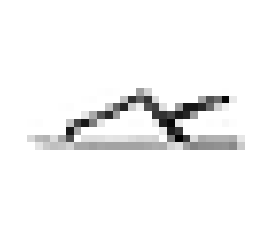

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [4]:
import matplotlib
import matplotlib.pyplot as plt

i = 3
#print(np.array(train_df.iloc[1]).reshape(28,28))
plt.imshow(np.array(train_df.iloc[5]).reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y_train[:,5])

##Classes:
# 0 	T-shirt/top
# 1 	Trouser
# 2 	Pullover
# 3 	Dress
# 4 	Coat
# 5 	Sandal
# 6 	Shirt
# 7 	Sneaker
# 8 	Bag
# 9 	Ankle boot


### Rede Neural com 1 Camada Escondida (Multi Class)

In [19]:
#ONE HIDDEN LAYER

classes = 10
n_hl = 32
learning_rate = 0.3

# Can be relu, sigmoid or tanh
activation_function = relu
#This is the derivative of the activation function denoted by <name>_
activation_function_ = relu_

iterations = 3000

df = train_df.T
Y = Y_train

n_x = df.shape[0]
m = df.shape[1]

weights_1 = np.random.randn(n_hl, n_x) * 0.01
b1 = np.zeros((n_hl, 1))
weights_2 = np.random.randn(classes, n_hl) *0.01
b2 = np.zeros((classes, 1))

start_time = time.time()
for i in range(iterations):

    #Feed forward
    hl_input = np.matmul(weights_1,df) + b1
    hl_output = activation_function(hl_input)
    ol_input = np.matmul(weights_2,hl_output) + b2
    ol_output = softmax(ol_input)

    #Calculate the error
    cost = multiclass_cross_entropy_loss(Y, ol_output)

    #Backpropagation
    d_ol_input = ol_output-Y
    d_weights_2 = (1./m) * np.matmul(d_ol_input, hl_output.T)
    d_b2 = (1./m) * np.sum(d_ol_input, axis=1, keepdims=True)

    d_hl_output = np.matmul(weights_2.T, d_ol_input)
    d_hl_input = d_hl_output * activation_function_(hl_input)
    d_weights_1 = (1./m) * np.matmul(d_hl_input, df.T)
    d_b1 = (1./m) * np.sum(d_hl_input, axis=1, keepdims=True)

    #Atualização dos pesos e biases
    weights_2 = weights_2 - learning_rate * d_weights_2
    b2 = b2 - learning_rate * d_b2
    weights_1 = weights_1 - learning_rate * d_weights_1
    b1 = b1 - learning_rate * d_b1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)

final_time = time.time() - start_time
print("Final cost:", cost)

Epoch 0 cost:  2.302254437312288
Epoch 100 cost:  0.7596372945334771
Epoch 200 cost:  0.5606936667361904
Epoch 300 cost:  0.5152609067253606
Epoch 400 cost:  0.4731752880655705
Epoch 500 cost:  0.4453109912710704
Epoch 600 cost:  0.42749030008447175
Epoch 700 cost:  0.4136468023202372
Epoch 800 cost:  0.4020598930089031
Epoch 900 cost:  0.38775448239730653
Epoch 1000 cost:  0.37427946860137146
Epoch 1100 cost:  0.3720391647969387
Epoch 1200 cost:  0.36558956106522467
Epoch 1300 cost:  0.36195124415921137
Epoch 1400 cost:  0.3480141578314059
Epoch 1500 cost:  0.3407822769338691
Epoch 1600 cost:  0.34455482848428504
Epoch 1700 cost:  0.330711161787308
Epoch 1800 cost:  0.33019638182425615
Epoch 1900 cost:  0.32537152119232327
Epoch 2000 cost:  0.3164805907404057
Epoch 2100 cost:  0.31031514349467626
Epoch 2200 cost:  0.3087669599256484
Epoch 2300 cost:  0.30887276554264803
Epoch 2400 cost:  0.3270505687553648
Epoch 2500 cost:  0.30253962207419494
Epoch 2600 cost:  0.2945926508538348
Epoc

In [21]:
prediction = predict_labels_1_hidden(weights_1, weights_2, b1, b2, normalized_validation_df, activation_function)

samples_number = prediction.shape[1]

predictions = np.argmax(prediction, axis=0)
labels = np.argmax(Y_validation, axis=0)

confusion_matrix = get_confusion_matrix(Y_validation, prediction, classes)

print(confusion_matrix)

precision, recall, f1_score = get_metrics(confusion_matrix)

print_metrics(precision, recall, f1_score)

[[1579    6   16   30   11    0  182    0   16    0]
 [  12 1756    2   35    6    0    4    0    0    0]
 [  34    4 1302   12  308    0  159    0   13    0]
 [  90   26   13 1492   93    0   57    0    4    0]
 [   8    3   76   42 1569    0  109    0    6    0]
 [   1    0    0    2    0 1720    0   49    9   30]
 [ 246    7  104   35  183    1 1221    0   19    0]
 [   0    0    0    0    0   49    0 1631    7   74]
 [   6    0    4    7   12   11   21    6 1728    1]
 [   0    0    1    0    0   25    0   41    3 1776]]


Precision (Pr), Recall (Re) and F1_Score (F1) of each class: 
Pr   Re    F1
0.86 0.8  0.83
0.97 0.97 0.97
0.71 0.86 0.78
0.84 0.9  0.87
0.87 0.72 0.79
0.95 0.95 0.95
0.67 0.7  0.68
0.93 0.94 0.94
0.96 0.96 0.96
0.96 0.94 0.95


Average Precision:  0.87 
Average Recall:  0.87 
Average F1_Score:  0.87


In [22]:
print("Tempo gasto: ", final_time)

Tempo gasto:  304.97782254219055


### Rede Neural com 2 Camadas Escondidas (Multiclasse)

In [17]:
#ONE HIDDEN LAYER

classes = 10
n_hl_1 = 32
n_hl_2 = 32
learning_rate = 0.3

activation_function = tanh
activation_function_ = tanh_

iterations = 3000

df = train_df.T
Y = Y_train

n_x = df.shape[0]
m = df.shape[1]

weights_1 = np.random.randn(n_hl_1, n_x) * 0.01
b1 = np.zeros((n_hl_1, 1))
weights_2 = np.random.randn(n_hl_2, n_hl_1) *0.01
b2 = np.zeros((n_hl_2, 1))
weights_3 = np.random.randn(classes, n_hl_2) *0.01
b3 = np.zeros((classes, 1))

start_time = time.time()
for i in range(iterations):

    #Feed forward
    hl_1_input = np.matmul(weights_1,df) + b1
    hl_1_output = activation_function(hl_1_input) 
    hl_2_input = np.matmul(weights_2,hl_1_output) + b2
    hl_2_output = activation_function(hl_2_input)
    ol_input = np.matmul(weights_3,hl_2_output) + b3
    ol_output = softmax(ol_input)

    #Calculate the error
    cost = multiclass_cross_entropy_loss(Y, ol_output)

    #Backpropagation
    d_ol_input = ol_output-Y
    d_weights_3 = (1./m) * np.matmul(d_ol_input, hl_2_output.T)
    d_b3 = (1./m) * np.sum(d_ol_input, axis=1, keepdims=True)
    
    d_hl_2_output = np.matmul(weights_3.T, d_ol_input)
    d_hl_2_input = d_hl_2_output * activation_function_(hl_2_input)
    d_weights_2 = (1./m) * np.matmul(d_hl_2_input, hl_1_output.T)
    d_b2 = (1./m) * np.sum(d_hl_2_input, axis=1, keepdims=True)

    d_hl_1_output = np.matmul(weights_2.T, d_hl_2_input)
    d_hl_1_input = d_hl_1_output * activation_function_(hl_1_input)
    d_weights_1 = (1./m) * np.matmul(d_hl_1_input, df.T)
    d_b1 = (1./m) * np.sum(d_hl_1_input, axis=1, keepdims=True)

    #Atualização dos pesos e biases
    weights_3 = weights_3 - learning_rate * d_weights_3
    b3 = b3 - learning_rate * d_b3
    weights_2 = weights_2 - learning_rate * d_weights_2
    b2 = b2 - learning_rate * d_b2
    weights_1 = weights_1 - learning_rate * d_weights_1
    b1 = b1 - learning_rate * d_b1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)
    
final_time = time.time() - start_time

print("Final cost:", cost)

Epoch 0 cost:  2.3024974971809304
Epoch 100 cost:  1.3595747828070868
Epoch 200 cost:  0.8619044208143345
Epoch 300 cost:  0.6634284236529474
Epoch 400 cost:  0.5882340048606266
Epoch 500 cost:  0.5474145661036904
Epoch 600 cost:  0.49747964394350097
Epoch 700 cost:  0.4812147011861902
Epoch 800 cost:  0.43495618673421566
Epoch 900 cost:  0.4369450464230194
Epoch 1000 cost:  0.42203620091970356
Epoch 1100 cost:  0.3855807499184543
Epoch 1200 cost:  0.4039447302378841
Epoch 1300 cost:  0.3844083332328202
Epoch 1400 cost:  0.3601098982372285
Epoch 1500 cost:  0.3634844080047194
Epoch 1600 cost:  0.34345831971705154
Epoch 1700 cost:  0.36436293840247774
Epoch 1800 cost:  0.33990781165092543
Epoch 1900 cost:  0.39048055819377225
Epoch 2000 cost:  0.3199028906073081
Epoch 2100 cost:  0.32926579188159916
Epoch 2200 cost:  0.3210403326074115
Epoch 2300 cost:  0.3034225933016322
Epoch 2400 cost:  0.29835388377993977
Epoch 2500 cost:  0.3039252185533242
Epoch 2600 cost:  0.2903535436782421
Epoc

In [20]:
prediction = predict_labels_2_hidden(weights_1, weights_2, weights_3, b1, b2, b3, normalized_validation_df, activation_function)


#Z1 = np.matmul(weights_1, normalized_validation_df.T) + b1
#A1 = relu(Z1)
#Z2 = np.matmul(weights_2, A1) + b2
#A2 = relu(Z2)
#Z3 = np.matmul(weights_3, A2) + b3
#A3 = softmax(Z3)

predictions = np.argmax(prediction, axis=0)
labels = np.argmax(Y_validation, axis=0)

confusion_matrix = get_confusion_matrix(Y_validation, prediction, classes)

print(confusion_matrix)

precision, recall, f1_score = get_metrics(confusion_matrix)

print_metrics(precision, recall, f1_score)

ValueError: shapes (10,32) and (10,18105) not aligned: 32 (dim 1) != 10 (dim 0)

In [15]:
print("Tempo gasto: ", final_time)

Tempo gasto:  430.2525317668915
